# Final Project Analysis
## Lauren Brodsky
## 5/9/25

In [2]:
# Packages used
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import scipy.stats as stats 
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from tbats import TBATS

# 1) Impact of Temperature:

## 1a) How does daily usage change with temperature?

In [5]:
# Linear regression and knn Regression

# read in cvs file
df = pd.read_csv("final_merged_data.csv")

In [6]:
# set  x and y 
X = df[['avg_temperature']] 
y = df['total_rides']

In [7]:
# train test/ split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [8]:
# K Nearest Neighbors
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [9]:
# Linear Regression and KNN Regression

# compare models using .score and show results
print("Linear Regression R^2 Score:", round(lr.score(X_test, y_test), 4))
print("KNN Regression R^2 Score:", round(knn.score(X_test, y_test), 4))
print("Linear  regression Coefficient", round(lr.coef_[0],4))

Linear Regression R^2 Score: 0.5115
KNN Regression R^2 Score: 0.4099
Linear  regression Coefficient 47.3704


In [10]:
# Ridge regression and lasso regression

# scale features to make the data more even 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # fit the traning data 
X_test_scaled = scaler.transform(X_test) # fit the testing data

# run ridge regression with alpha set as 1 
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

# run lasso regression with alpha set the same 
lasso = Lasso(alpha=1.0)
lasso.fit(X_train_scaled, y_train)

# print r^2 to see how well each model did  
print("Ridge regression R^2 Score:", round(ridge.score(X_test_scaled, y_test), 4))
print("Lasso Regression R^2 Score:", round(lasso.score(X_test_scaled, y_test), 4))

Ridge regression R^2 Score: 0.5116
Lasso Regression R^2 Score: 0.5115


### The Linear Regression predicted bike usage better than KNN, explaining 51.15% of the changes in ride counts, while KNN explained 40.99%.The ridge and Lasso Regression gave almost the same results to Linear Regression, with R^2 scores of 0.5116 and 0.5115. As temperature rises, bike usage increases about 47 more rides per 1 degree based on the coefficient.

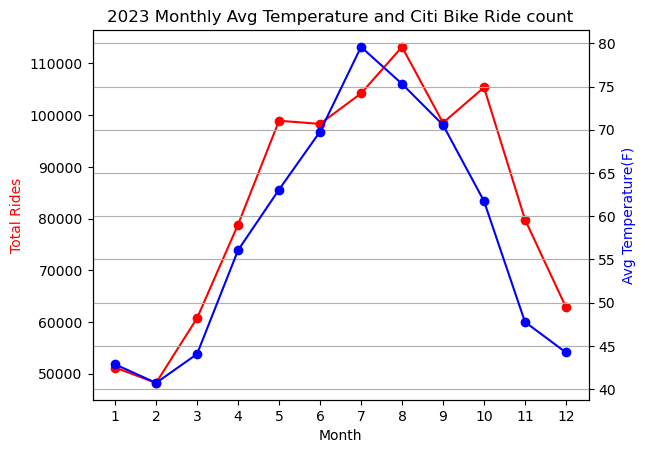

In [12]:
# Monthly Trendline
# used to futher prove the Linear Regression by showing monthly trends 
# (unlike the scatter plot in 1b which shows each individual data points)


# prepare data group by month avg temp and toatl rides 
# get the month from date column
df['date'] = pd.to_datetime(df['date']) # < convert to datetime (date is alredy in datetime but just incase) 
df['month'] = df['date'].dt.month 

# get sum number of rides per month AND avg temp
monthly_sum = df.groupby('month')[['avg_temperature', 'total_rides']].agg({'avg_temperature': 'mean',  'total_rides': 'sum'  })

# create the figure 
fig,  ax1 = plt.subplots()

# plot the total rides add a marker to see where each plot is and add a lable 
ax1.plot(monthly_sum.index, monthly_sum['total_rides'], color='red', marker='o') 

# set x and y lables
ax1.set_xlabel('Month') # don't set color/ keep black
ax1.set_ylabel('Total Rides', color='red') # set lable the same color 

# show all the months on x -axis jan-dec
ax1.set_xticks(range(1, 13))  

# add the second y axis for temp
ax2 = ax1.twinx() # creates 2nd y axis 
ax2.plot(monthly_sum.index, monthly_sum['avg_temperature'], color='blue', marker='o')  
ax2.set_ylabel('Avg Temperature(F)', color='blue') # set blue

# add title 
plt.title('2023 Monthly Avg Temperature and Citi Bike Ride count')
plt.grid(True) # add grid to see graph better
plt.show() # show 

### The graph supports the linear regression model, which found that rides increase by about 47 for every 1  degree(F) increase. As shown, both temperature and ride counts peak in summer and drop in winter, confirming this trend.

## 1b) Is there a noticeable trend in rides peaking at certain temperature ranges?

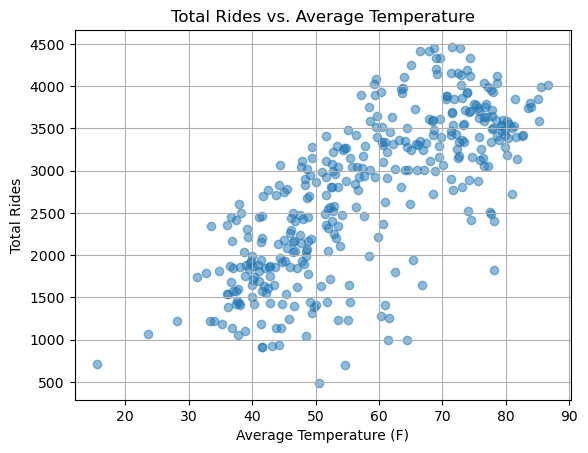

In [15]:
#Scatterplot

# unlike the monthly trend in 1a, this focuses on individual data points rather than monthly averages

# create scatter plot
plt.scatter(df['avg_temperature'], df['total_rides'], alpha=0.5)

# set x and y
plt.xlabel('Average Temperature (F)')
plt.ylabel('Total Rides')

# add a grid for readability
plt.grid(True)

# set title
plt.title('Total Rides vs. Average Temperature')

#show plot
plt.show()

### There’s a clear upward trend, bike rides increase as temperature rises, with higher usage from about 60F to 85F. No strong peak or drop off is seen.

## 1c) Does ride duration change with temperature?

In [18]:
# Summary stats

#create  analysis for ride duuration 
# this was done do better understand the typical ride duration 
print("Summary stats for ride duration: ")
print(df['average_ride_duration'].describe())

Summary stats for ride duration: 
count    365.000000
mean      14.515356
std        2.521857
min        9.138095
25%       12.690448
50%       14.134166
75%       15.663392
max       25.611945
Name: average_ride_duration, dtype: float64


### Most rides last around 14.5 minutes, with durations typically ranging between 9 and 25 minutes. Rides peak around 13–15 minutes.

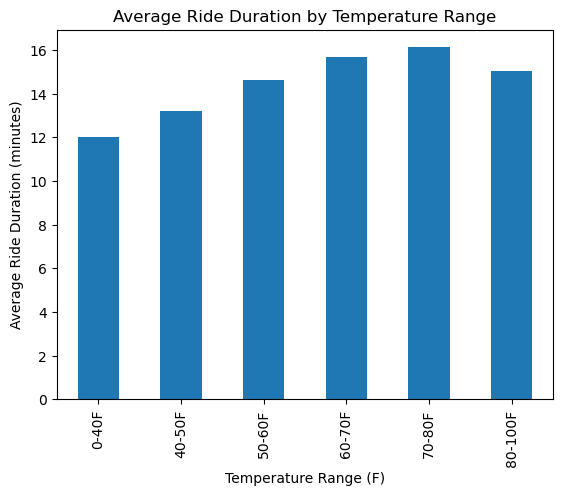

temp_range
0-40F      11.997752
40-50F     13.220502
50-60F     14.613766
60-70F     15.667624
70-80F     16.118619
80-100F    15.019543
Name: average_ride_duration, dtype: float64


In [20]:
# Binned bar chart

# define temp bins for label 
bins = [0, 40, 50, 60, 70, 80, 100]
labels = ['0-40F', '40-50F', '50-60F', '60-70F', '70-80F', '80-100F']

# create a new column in new df that sets each row to the temp range
df['temp_range'] = pd.cut(df['avg_temperature'], bins=bins, labels=labels)

# group by temperature bin and calculate average ride duration
#observed=True > only show what temp is in the df 
avg_duration_bin= df.groupby('temp_range', observed=True)['average_ride_duration'].mean()

# plot the bar chart
avg_duration_bin.plot(kind='bar')
# add title and lables
plt.title("Average Ride Duration by Temperature Range")
plt.xlabel("Temperature Range (F)")
plt.ylabel("Average Ride Duration (minutes)")
plt.show()

# prints the  numbers to see the actual numbers 
print(avg_duration_bin)

### People ride longer as it gets warmer, with the longest rides at 70–80F. Ride duration drops a slighlty above 80F.

In [22]:
# t-test > hypothesis test 

# create a filter for the two temperature groups > warm and cold
cold = df[df['temp_range'] == '0-40F']['average_ride_duration']
warm = df[df['temp_range'] == '70-80F']['average_ride_duration']

# Run the  t -test
# use welch t test in case  variances are unequal
t_stat, p_value = stats.ttest_ind(cold, warm, equal_var=False)

# print stats 
print(f"T -statistic {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

T -statistic -12.3709
P-value: 0.0000


### The T statistic of -12.37 and p value of 0.0000 mean there is a strong difference in ride duration. This means that people ride much less in cold weather (0–40F) than in warm weather (70–80F).

# 2) impact on Precipitation:

## 2a) What is the impact of rain on bike usage? 

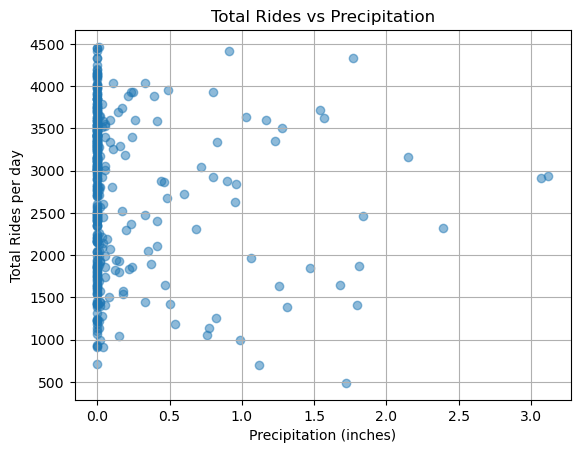

In [26]:
# create scatter plot

# use precipitation and total rides columns
plt.scatter(df['precipitation_in'],  df['total_rides'], alpha=0.5) 
plt.title("Total Rides vs Precipitation") # set title 
plt.xlabel("Precipitation (inches)") # set x lable 
plt.ylabel("Total Rides per day") # set y label 
plt.grid(True) # add a grid
plt.show() # show plot

In [27]:
# calculate correlation between rain and ride counts
correlation = df['precipitation_in'].corr(df['total_rides'])
print("Correlation between precipitation and total rides is", round(correlation, 4))

Correlation between precipitation and total rides is -0.0788


### There is a weak negative correlation between precipitation and total rides (r = -0.0788), meaning rain has a small effect on lowering bike usage. Most rides happen on dry days, but rides still occur with light or moderate rain.

## 2b) Are classic bikes more popular than electric bikes during rainy weather? 

In [30]:
# Grouped bar chart

# Create a temporary rain level column > so it does not chnage the orgainal csv
# create  list to store data
rain_levels = []

for value in df['precipitation_in']:
    if value == 0:
        rain_levels.append("No Rain")
    elif value < 0.3:
        rain_levels.append("Light Rain")
    else:
        rain_levels.append("Heavy Rain")

In [31]:
# create a temporay df with the rain leavls 
df_temp = df.copy()
df_temp['rain_category'] = rain_levels

In [32]:
# group and compare classic, electric,  and docked bike averages to show avg bike usage by type and rain level
bike_avg = df_temp.groupby('rain_category')[['classic_bikes', 'electric_bikes', 'docked_bikes']].mean()
bike_avg # shows the same thing as the bar

,classic_bikes,electric_bikes,docked_bikes
rain_category,,,
Heavy Rain,2295.862745,219.352941,3.568627
Light Rain,2204.310811,303.324324,5.000000
No Rain,2570.733333,280.191667,5.770833


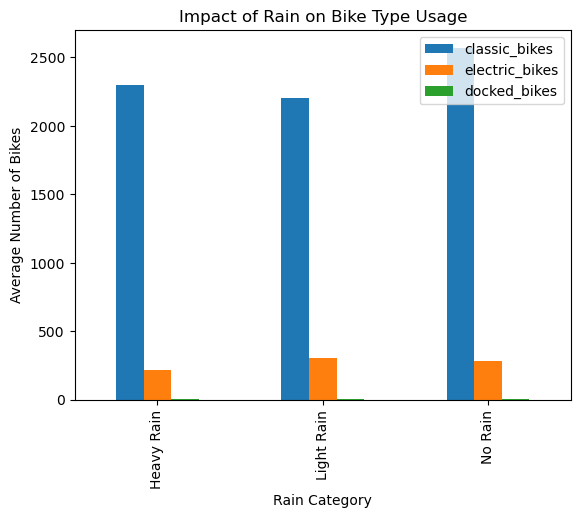

In [33]:
# create bar chrt for better visualization using same data

# plot each bike type 
bike_avg.plot(kind='bar')
plt.title("Impact of Rain on Bike Type Usage")
plt.ylabel("Average Number of Bikes")
plt.xlabel("Rain Category")
plt.show()

In [34]:
# percent change analysis

# I calculated the percent drop to fairly compare rain impact bc all bike types have different overall usage 

# use .loc to slect rows in df
# use formula: percent change = current value - baseline value  / baseline value * 100 
# percent change = heavy rain - no rain / no rain * 100 (shows bike usage being dropped in rain)
percent_change = ((bike_avg.loc['Heavy Rain'] - bike_avg.loc['No Rain']) / bike_avg.loc['No Rain']) * 100

# print results
print("Percent change in bike usage from no rain to heavy rain")
print(percent_change)

Percent change in bike usage from no rain to heavy rain
classic_bikes    -10.692303
electric_bikes   -21.713253
docked_bikes     -38.160968
dtype: float64


### Classic bikes are more popular than electric bikes during rainy weather. Classic bikes have a higher usage and a smaller drop in rides during heavy rain (-10.7% vs. -21.7%). Docked bikes are used very little overall (3–6 rides on average per day), which is why their bars are not visible when plotted with classic and electric bikes.

## 2c) Do people ride longer when it rains?

In [37]:
# Grouped mean 

# group by rain category and calculate average ride duration
avg_duration = df_temp.groupby('rain_category')['average_ride_duration'].mean()

# show results
print("Average ride duration by rain level:")
print(avg_duration)

Average ride duration by rain level:
rain_category
Heavy Rain    14.687448
Light Rain    14.229537
No Rain       14.566914
Name: average_ride_duration, dtype: float64


### On average, people ride a little longer when it’s raining heavily compared to dry or lightly rainy days.

In [39]:
# ANOVA test to see if the chnage is actually signifcant 

# split data into groups and use categories from 2b so I don't need to create new ones
# make sure to use temp_df bc thats is where rain_category was created to
heavy = df_temp[df_temp['rain_category'] == 'Heavy Rain']['average_ride_duration'] # for heavy rain
light = df_temp[df_temp['rain_category'] == 'Light Rain']['average_ride_duration'] # light rain 
none = df_temp[df_temp['rain_category'] == 'No Rain']['average_ride_duration'] # no rain 

# run ANOVA get the f stat and p value 
f_stat, p_value = stats.f_oneway(heavy, light, none)

# print results
print(f"F-stat: {f_stat:.4f}")
print(f"p -value: {p_value:.4f}")

F-stat: 0.6429
p -value: 0.5264


### The F-statistic of 0.6429 and p-value of 0.5264 show no significant difference in ride duration across rain levels. Therefore, we can conclude that ride times are similar in heavy, light, and no rain.

# 3) User Types:

## 3a) Are casual users (day pass riders) more sensitive to weather than members?

In [43]:
# User type percent change by rain  grouped mean

# reuse rain category column from 2b
# group by rain and user type and calculate avg number of rides by user type
rain_user_avg = df_temp.groupby('rain_category')[['rides_by_members', 'rides_by_casual']].mean()
# print avg ride results 
print("Average number of rides by user type and rain level")
print(rain_user_avg)

# now show percent change to better understand the change 
# use formula: percent change = current value - baseline value  / baseline value * 100  >> # set baseline at no rain
percent_change_rain = ((rain_user_avg - rain_user_avg.loc['No Rain']) / rain_user_avg.loc['No Rain']) * 100
# print precent change results
print("\nPercent change in rides by user type and rain level (vs no rain)")
print(percent_change_rain)

Average number of rides by user type and rain level
               rides_by_members  rides_by_casual
rain_category                                   
Heavy Rain          2032.294118       486.490196
Light Rain          2068.027027       444.608108
No Rain             2324.545833       532.150000

Percent change in rides by user type and rain level (vs no rain)
               rides_by_members  rides_by_casual
rain_category                                   
Heavy Rain           -12.572422        -8.580251
Light Rain           -11.035223       -16.450605
No Rain                0.000000         0.000000


### Casual rides drop more in light rain (-16.45%) than member rides (-11.04%), but less in heavy rain (-8.58% vs. -12.57%).")

In [45]:
# User type percent change by temp and  grouped mean

# group by temp range and calculate average rides by user type
#observed=True > only show what temp is in the df 
# reuse temp_range from 1c
temp_user_avg = df_temp.groupby('temp_range', observed=True)[['rides_by_members', 'rides_by_casual']].mean()
# print results 
print("Average number of rides by user type and temp range")
print(temp_user_avg)

# percent change = current value - baseline value / baseline value * 100 >>  set baseline at 0-40F for cold
percent_change_temp = ((temp_user_avg - temp_user_avg.loc['0-40F']) / temp_user_avg.loc['0-40F']) * 100
# print precent chnage results
print("\nPercent change in rides by user type and temp range (vs 0 –40F)")
print(percent_change_temp)

Average number of rides by user type and temp range
            rides_by_members  rides_by_casual
temp_range                                   
0-40F            1515.295455       195.818182
40-50F           1739.744186       292.860465
50-60F           2236.885714       475.657143
60-70F           2559.984127       635.666667
70-80F           2731.602410       778.084337
80-100F          2826.157895       721.157895

Percent change in rides by user type and temp range (vs 0 –40F)
            rides_by_members  rides_by_casual
temp_range                                   
0-40F               0.000000         0.000000
40-50F             14.812209        49.557341
50-60F             47.620433       142.907547
60-70F             68.942903       224.620860
70-80F             80.268634       297.350404
80-100F            86.508703       268.279333


### Casual rides increase more with rising temperatures, peaking at 70–80F (297.35%), compared to member rides (80.26%), indicating casual riders are more sensitive to temperature changes.

In [47]:
# User type percent change by wind  grouped mean

# wind by user type
# create wind bins
wind_bins = [0, 10, 15, 20, 30, 100]  # set wind speed
wind_labels = ['0-10mph', '10- 15 mph', '15- 20 mph', ' 20- 30 mph', '30 + mph'] # set lables

# create a new column with the bin wind 
df_temp['wind_range'] = pd.cut(df_temp['wind_speed_mph'], bins=wind_bins, labels=wind_labels)
# group by the wind bin and get average rides by user type
wind_user_avg = df_temp.groupby('wind_range', observed=True)[['rides_by_members', 'rides_by_casual']].mean()
# show the results for avg use wind by memeber
print("Average number of rides by user type and wind speed")
print(wind_user_avg)

# current - baseline / baseline * 100 >> set baseline at 0-10 mph
percent_change_wind = ((wind_user_avg - wind_user_avg.loc['0-10mph']) / wind_user_avg.loc['0-10mph']) * 100
# print precent chnage results
print("\nPercent change in rides by user type and wind speed (vs 0– 10 mph)") 
print(percent_change_wind)

Average number of rides by user type and wind speed
             rides_by_members  rides_by_casual
wind_range                                    
0-10mph           2291.720000       554.080000
10- 15 mph        2468.062016       596.310078
15- 20 mph        2254.790909       514.736364
 20- 30 mph       1911.242105       381.778947
30 + mph          1550.666667       293.666667

Percent change in rides by user type and wind speed (vs 0– 10 mph)
             rides_by_members  rides_by_casual
wind_range                                    
0-10mph              0.000000         0.000000
10- 15 mph           7.694745         7.621657
15- 20 mph          -1.611414        -7.100714
 20- 30 mph        -16.602285       -31.096783
30 + mph           -32.336120       -46.999230


### Casual rides decrease more at higher wind speeds, especially at 30+mph (-46.99%), compared to member rides (-32.34%), showing casual riders are more sensitive to strong wind conditions.

# 4) Forecasting Future Usage:

## 4a) How many Citi Bike rides are expected in the next 90 days based on past trends?

In [51]:
# time series forecasting using ARIMA

y = df['total_rides'] # set total_rides column to forecast
model = ARIMA(y, order=(1, 1, 1)).fit() # train the ARIMA model on all data

# create forecast for the next 90 days
forecast = model.forecast(steps=90)
# calculate the total number of rides predicted for 90 days
total_forecast_rides = forecast.sum()

# show the result
print(f" Estimated total rides in the next 90 days: {int(total_forecast_rides)}")


# now show the mae to see how accurate the model is
actual = y[-90:] # set to 90 days to see last 90 days
mae = mean_absolute_error(actual, forecast) # finds how far off the predictions are 
print(f"MAE: {mae:.1f}") 

 Estimated total rides in the next 90 days: 162196
MAE: 1049.6


### The ARIMA model forecasted about 162,196 rides over the next 90 days. The MAE of 1,049 means that the model’s daily predictions were off by about 1,049 rides on average. 

In [53]:
# tbats 

# fix date to datetime > before adding this the date in the gragh showed the date wrong
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)  

# select total_rides column
y = df['total_rides']

# split data 
train = y[:-90] # use all but last 90 days for test 
test = y[-90:] # use last 90 for testing

# create tbats modle with weekly(7) seasonlity and fit to train data
tbats = TBATS(seasonal_periods=[7])
model = tbats.fit(train)

# forecast for the next 90 days
forecast = model.forecast(steps=90)
forecast_dates = test.index # match forecast dates to the real test dates

# calculate the mae
mae = mean_absolute_error(test, forecast)
print(f"MAE: {mae:.2f}")
print(f"estimated total rides in next 90 days: {int(forecast.sum())}")

MAE: 789.16
estimated total rides in next 90 days: 286593


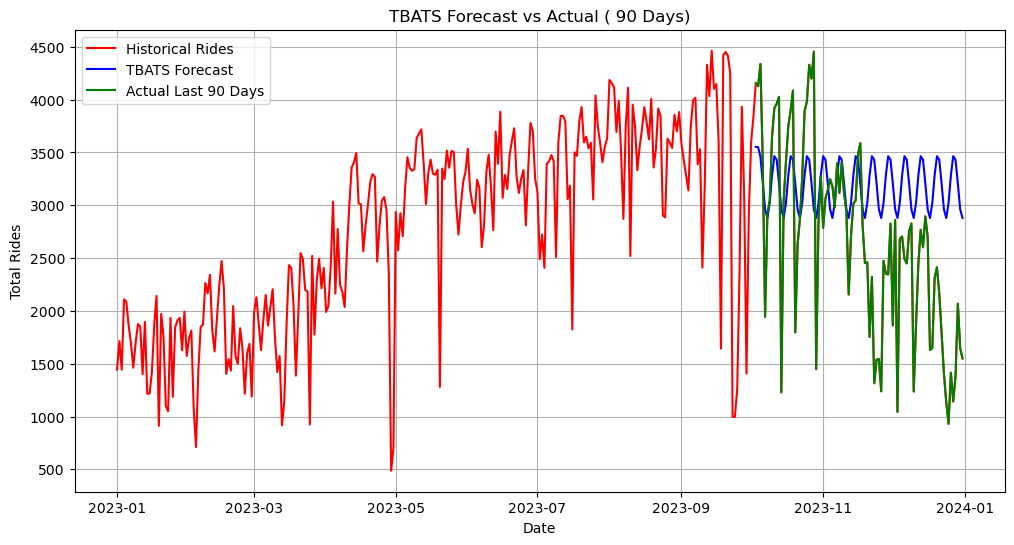

In [54]:
# plot tbats because it has the lowest mae

# set figure size
plt.figure(figsize=(12, 6))

# plot historcal data (y) using ride counts in red
plt.plot(y.index, y, label='Historical Rides', color='red')
# plot tbats forecasted rides (forecast) over forecasted dates in blue
plt.plot(forecast_dates, forecast, label='TBATS Forecast', color='blue')
# plot actual last 90 days of actual rides (test) in green
plt.plot(test.index, test, label='Actual Last 90 Days', color='green')

# set title and x and y lable
plt.title('TBATS Forecast vs Actual ( 90 Days)')
plt.xlabel('Date')
plt.ylabel('Total Rides')
# add a legend and show the plot
plt.legend()
plt.grid(True)
plt.show()

### The TBATS model forecasted about 286,593 rides over the next 90 days. The MAE of 789 means that the model’s daily predictions were off by about 789 rides on average. Since this MAE is lower than ARIMA model (1,049), TBATS is more accurate for this dataset.